In [1]:
import tensorflow as tf

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np
from shutil import move
import random
import math

In [4]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# Define Useful Constants

In [5]:
label1 = 'herringbone'
label2 = 'lattice'
root_dir ='F:\\Research\\'
labels = ['herringbone','lattice']

# Data Loading

Read STM Au(111) data into memory via ImageDataGenerator.

In [6]:
img_dir =  os.path.join(root_dir, 'Labeled Images - Au(111)')
lattice_src_dir = os.path.join(img_dir, 'atomic-lattice-clear')
herringbone_src_dir = os.path.join(img_dir, 'herringbone-clear')
sources = [herringbone_src_dir, lattice_src_dir]

## Inspect the data

In [7]:
total_herringbone = len(os.listdir(herringbone_src_dir))
total_lattice = len(os.listdir(lattice_src_dir))

num_herringbone_tr = math.floor(total_herringbone * 0.75)
num_lattice_tr =  math.floor(total_lattice * 0.75)

num_herringbone_val =  math.floor(total_herringbone * 0.25)
num_lattice_val =  math.floor(total_lattice * 0.25)

total_train = num_herringbone_tr + num_lattice_tr
total_val = num_herringbone_val + num_lattice_val

num_vals = [num_herringbone_val, num_lattice_val]

In [8]:
print('total herringbone images:', total_herringbone)
print('total lattice images:', total_lattice)
print("--")
print('total training herringbone images:', num_herringbone_tr)
print('total training notherringbone images:', num_lattice_tr)
print('total validation herringbone images:', num_herringbone_val)
print('total validation notherringbone images:', num_lattice_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total herringbone images: 74
total lattice images: 34
--
total training herringbone images: 55
total training notherringbone images: 25
total validation herringbone images: 18
total validation notherringbone images: 8
--
Total training images: 80
Total validation images: 26


## Define train and validation locations

In [9]:
out = '-'.join(labels)
out_dir = os.path.join(root_dir, 'datasets', out)
train_dir = os.path.join(out_dir, 'train')
validation_dir = os.path.join(out_dir, 'validation')

## Re-order train and vlidation images

In [10]:
def move_random_sample(src_dir, dst_dir, label, sample_size):
    try:
        sample = random.sample(os.listdir(src_dir), k=sample_size)
        for index, file in enumerate(sample):
            src_path = os.path.join(src_dir,file)
            dst_path = os.path.join(dst_dir,'{}.{}.jpg'.format(label,index))
            os.makedirs(os.path.dirname(dst_path), exist_ok=True)
            move(src_path, dst_path)

    except Exception as e:
        raise e
        print("Error! No files found here")

    print('Complete')

In [11]:
def move_all(src_dir, dst_dir, label):
    try:
        for index, file in enumerate(os.listdir(src_dir)):
            src_path = os.path.join(src_dir,file)
            dst_path = os.path.join(dst_dir,'{}.{}.jpg'.format(label,index))
            os.makedirs(os.path.dirname(dst_path), exist_ok=True)
            move(src_path, dst_path)

    except Exception as e:
        raise e
        print("Error! No files found here")

    print('Complete.')

In [12]:
training_label_dirs = list(map(lambda label: os.path.join(train_dir, label), labels))
validation_label_dirs = list(map(lambda label: os.path.join(validation_dir, label), labels))

for index, label in enumerate(labels):
    # Move validation images 
    move_random_sample(sources[index], validation_label_dirs[index], label, num_vals[index])
    # Move remaining training images
    move_all(sources[index], training_label_dirs[index], label)

Complete
Complete.
Complete
Complete.


# Set Model Parameters

In [13]:
# Number of training examples to process before updating our models variables
BATCH_SIZE = 100 
# Our training data consists of images with width of 150 pixels and height of 150 pixels
IMG_SHAPE  = 150

# Data Preparation 

Images must be formatted into appropriately pre-processed floating point tensors before being fed into the network. The steps involved in preparing these images are:

1. Read images from the disk
2. Decode contents of these images and convert it into proper grid format as per their RGB content
3. Convert them into floating point tensors
4. Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.

Fortunately, all these tasks can be done using the class **tf.keras.preprocessing.image.ImageDataGenerator**.

We can set this up in a couple of lines of code.

In [14]:
# Generator for our training data
train_image_generator      = ImageDataGenerator(rescale=1./255)
# Generator for our validation data
validation_image_generator = ImageDataGenerator(rescale=1./255)  

After defining our generators for training and validation images, **flow_from_directory** method will load images from the disk, apply rescaling, and resize them using single line of code.

In [15]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), 
                                                           class_mode='binary')

Found 193 images belonging to 2 classes.


In [16]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), 
                                                              class_mode='binary')

Found 63 images belonging to 2 classes.


### Visualizing Training images

We can visualize our training images by getting a batch of images from the training generator, and then plotting a few of them using `matplotlib`.

In [17]:
sample_training_images, _ = next(train_data_gen) 

In [18]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

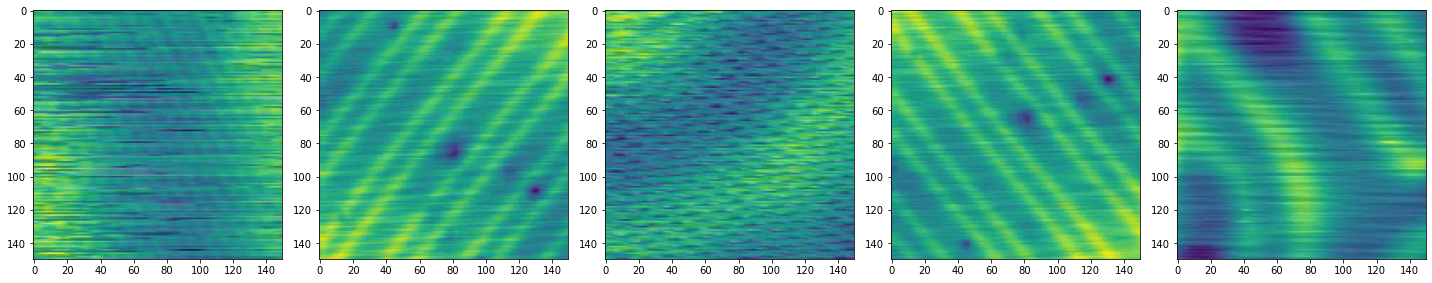

In [19]:
plotImages(sample_training_images[:5])  # Plot images 0-4

# Data Augmentation

Overfitting often occurs when we have a small number of training examples. One way to fix this problem is to augment our dataset so that it has sufficient number and variety of training examples. Data augmentation takes the approach of generating more training data from existing training samples, by augmenting the samples through random transformations that yield believable-looking images. The goal is that at training time, your model will never see the exact same picture twice. This exposes the model to more aspects of the data, allowing it to generalize better.

In tf.keras we can implement this using the same ImageDataGenerator class we used before. We can simply pass different transformations we would want to our dataset as a form of arguments and it will take care of applying it to the dataset during our training process.

To start off, let's define a function that can display an image, so we can see the type of augmentation that has been performed. Then, we'll look at specific augmentations that we'll use during training.


In [20]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

## Combine all augmentations

We can apply all these augmentations, and even others, with just one line of code, by passing the augmentations as arguments with proper values.

Here, we have applied rescale, rotation of 45 degrees, width shift, height shift, horizontal flip, and zoom augmentation to our training images.


In [21]:
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='binary')

Found 193 images belonging to 2 classes.


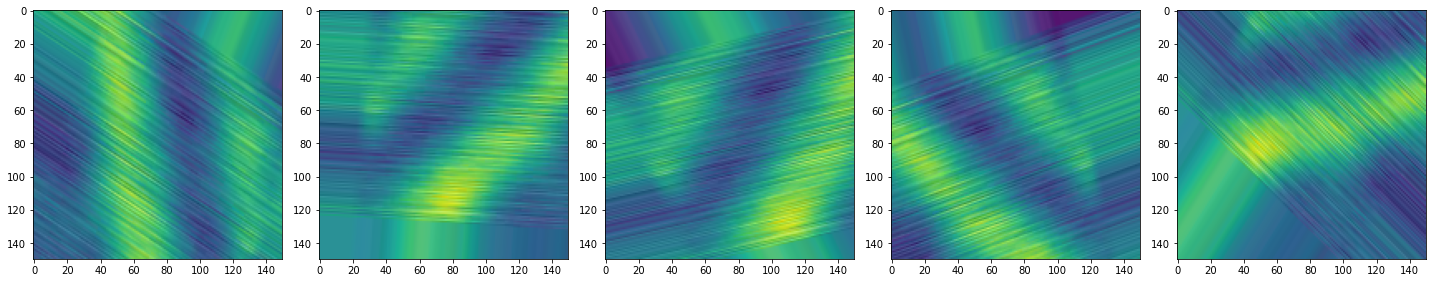

In [22]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Creating Validation Data generator

Generally, we only apply data augmentation to our training examples, since the original images should be representative of what our model needs to manage. So, in this case we are only rescaling our validation images and converting them into batches using ImageDataGenerator.

In [23]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=validation_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='binary')

Found 63 images belonging to 2 classes.


# Model Creation

## Define the model

The model consists of four convolution blocks with a max pool layer in each of them.

Before the final Dense layers, we're also applying a Dropout probability of 0.5. It means that 50% of the values coming into the Dropout layer will be set to zero. This helps to prevent overfitting.

Then we have a fully connected layer with 512 units, with a `relu` activation function. The model will output class probabilities for two classes — dogs and cats — using `softmax`. 

In [24]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
])

In [25]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

## Train updated model

In [27]:
# Since our batches are coming from a generator (ImageDataGenerator), we'll use fit_generator instead of fit.
epochs=400
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

Epoch 1/400
1/1 [==============================] - 1s 813ms/step - loss: 0.6839 - accuracy: 0.6559 - val_loss: 1.4358 - val_accuracy: 0.7143
Epoch 2/400
1/1 [==============================] - 0s 339ms/step - loss: 1.5494 - accuracy: 0.6900 - val_loss: 0.6120 - val_accuracy: 0.7143
Epoch 3/400
1/1 [==============================] - 0s 342ms/step - loss: 0.5634 - accuracy: 0.7600 - val_loss: 0.6579 - val_accuracy: 0.7143
Epoch 4/400
1/1 [==============================] - 0s 369ms/step - loss: 0.6457 - accuracy: 0.7204 - val_loss: 0.6696 - val_accuracy: 0.7143
Epoch 5/400
1/1 [==============================] - 0s 346ms/step - loss: 0.6690 - accuracy: 0.6667 - val_loss: 0.6594 - val_accuracy: 0.7143
Epoch 6/400
1/1 [==============================] - 0s 366ms/step - loss: 0.6479 - accuracy: 0.7312 - val_loss: 0.6333 - val_accuracy: 0.7143
Epoch 7/400
1/1 [==============================] - 0s 339ms/step - loss: 0.6178 - accuracy: 0.7312 - val_loss: 0.6069 - val_accuracy: 0.7143
Epoch 8/400
1

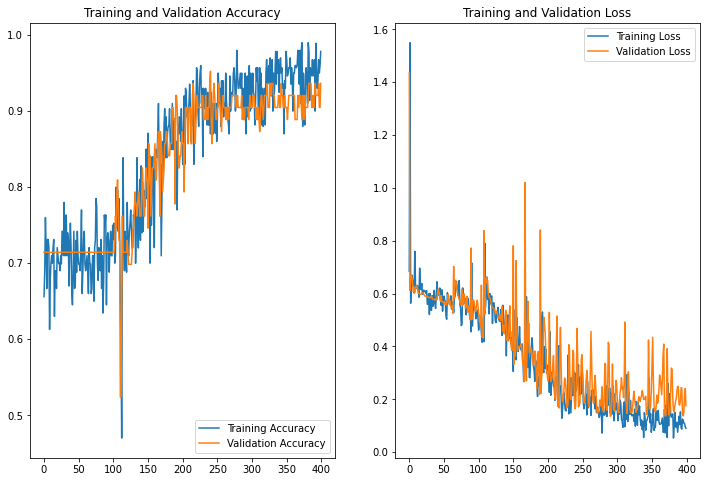

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Make Predictions

In [29]:
unclear_herringbone_src_dir = os.path.join(img_dir, 'herringbone-unclear')
image_gen_val = ImageDataGenerator(rescale=1./255)
unclear_herringbone_img_gen = image_gen_val.flow_from_directory(directory=img_dir,
                                                 # only read images from `test` directory
                                                 classes=['herringbone-unclear'],
                                                 # don't generate labels
                                                 batch_size=BATCH_SIZE,
                                                 # don't shuffle
                                                 shuffle=False,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE))
preds = model.predict_generator(test_gen)

Found 1411 images belonging to 1 classes.


NameError: name 'test_gen' is not defined

In [ ]:
plt.plot(preds)

In [ ]:
from functools import reduce
predicted_class = np.argmax(preds, axis=1)
plt.plot(predicted_class)
numCorrect = reduce((lambda x, y: x + y if y > 0 else x), predicted_class)
print(numCorrect/len(predicted_class))

In [ ]:
steps_clear = os.path.join(img_dir,'steps-clear')
image_gen_val = ImageDataGenerator(rescale=1./255)
steps_clear_img_gen = image_gen_val.flow_from_directory(directory=img_dir,
                                                 # only read images from `test` directory
                                                 classes=['steps-clear'],
                                                 # don't generate labels
                                                 batch_size=BATCH_SIZE,
                                                 # don't shuffle
                                                 shuffle=False,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE))

In [ ]:
preds = model.predict_generator(steps_clear_img_gen)
plt.plot(preds)

In [ ]:
from functools import reduce
predicted_class = np.argmax(preds, axis=1)
plt.plot(predicted_class)
numCorrect = reduce((lambda x, y: x + y if y == 0 else x), predicted_class)
print(numCorrect/len(predicted_class))

In [ ]:
img_path = os.path.join(unclear_herringbone_src_dir, 'herringbone_unclear.1079.jpg')
img = plt.imread(img_path)
plt.imshow(img)
img = load_img(img_path, target_size=(150, 150))
x = img_to_array(img)
x = x.reshape((1,) + x.shape)
x /= 255.0
predicted_class = np.argmax(model.predict(x))
print(predicted_class)

In [ ]:
#Iterate thru all the layers of the model
for layer in model.layers:
    if 'conv' in layer.name:
        weights, bias= layer.get_weights()
        print(layer.name)
        
        #normalize filter values between  0 and 1 for visualization
        f_min, f_max = weights.min(), weights.max()
        filters = (weights - f_min) / (f_max - f_min)  
        print(filters.shape)
        filter_cnt=1
        
        #plotting all the filters
        for i in range(filters.shape[3]):
            #get the filters
            filt=filters[:,:,:, i]
            
            # Save feature for later plotting
            filter_filepath = os.path.join(out_dir,'Binary Au111 CNN kernals', '{}_kernal-{}.png'.format(layer.name, i))
            plt.imsave(filter_filepath, filt[:,:, j])
                
            #plotting each of the channel, color image RGB channels
            for j in range(filters.shape[0]):
                ax= plt.subplot(filters.shape[3], filters.shape[0], filter_cnt)
                ax.set_xticks([])
                ax.set_yticks([])
                plt.imshow(filt[:,:, j])
            
                filter_cnt+=1
        plt.show()

In [ ]:
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
img_path = os.path.join(unclear_herringbone_src_dir, 'herringbone_unclear.1079.jpg')
img = load_img(img_path, target_size=(150, 150))
x = img_to_array(img)
x = x.reshape((1,) + x.shape)
x /= 255.0

In [ ]:
successive_feature_maps = visualization_model.predict(x)

In [ ]:
# Retrieve are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    print(feature_map.shape)
    if len(feature_map.shape) == 4:
        # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers
        n_features = feature_map.shape[-1]  # number of features in the feature map
        size = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
        
        # We will tile our images in this matrix
        display_grid = np.zeros((size, size * n_features))
        
        # Postprocess the feature to be visually palatable
        for i in range(n_features):
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std()
            x *=  64
            x += 128
            x  = np.clip(x, 0, 255).astype('uint8')
            
            # Save feature for later plotting
            feature_filepath = os.path.join(out_dir,'Binary Au111 CNN f-maps', '{}_feature-{}.png'.format(layer_name, i))
            plt.imsave(feature_filepath, x)
            
            # Tile each filter into a horizontal grid
            display_grid[:, i * size : (i + 1) * size] = x# Display the grid

        scale = 20. / n_features
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow( display_grid, aspect='auto', cmap='viridis' )